In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct

In [2]:
np.random.seed(0)

In [3]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [4]:
train_images = read_idx('./data/train-images.idx3-ubyte')
train_images = train_images.reshape(60000, 28*28)

In [5]:
train_labels = read_idx('./data/train-labels.idx1-ubyte')
one_hot = np.zeros((train_labels.shape[0], 10))
one_hot[np.arange(train_labels.shape[0]), train_labels] = 1
train_labels = one_hot

In [6]:
test_images = read_idx('./data/t10k-images.idx3-ubyte')
test_images = test_images.reshape(10000, 28*28)
test_labels = read_idx('./data/t10k-labels.idx1-ubyte')

In [7]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [8]:
class Layer:
    def __init__(self, input_size, size, activation_function, activation_prime, W=None, b=None, init=None):
        self.size = size
        if W == None:
            if init == None:
                self.W = np.random.normal(0, 0.001, (size, input_size))
        else:
            self.W = np.copy(W)
        self.b = np.zeros(size)
        self.error = np.zeros(size)
        self.func = activation_function
        self.func_prime = activation_prime
        
    def predict(self, a):
        self.a_in = np.copy(a)
        self.z = self.b + self.W.dot(a)
        self.a = self.func(self.z)
        return self.a
    
    def backprop(self, learning_rate, W=None, error=None, loss=[]):
        if len(loss) == 0:
            self.error = W.transpose().dot(error) * self.func_prime(self.z)
        else:
            self.error = loss * self.func_prime(self.z)
        self.W -= learning_rate * np.outer(self.error, self.a_in)
        self.b -= learning_rate * self.error
        
    def backprop_adam(self, alpha, m_hat, v_hat, epsilon, W=None, error=None, loss=[]):
        if len(loss) == 0:
            self.error = W.transpose().dot(error) * self.func_prime(self.z)
        else:
            self.error = loss * self.func_prime(self.z)
        self.W -= learning_rate * np.outer(self.error, self.a_in)
        self.b -= learning_rate * self.error
        return self.W, self.error

In [9]:
class MLP:
    def __init__(self, input_size, output_size, *layers):
        self.input_size = input_size
        self.output_size = output_size
        
        self.hidden_layers = layers
        self.output_layer = Layer(self.hidden_layers[-1].size, self.output_size, np.tanh, lambda x:1-np.tanh(x)**2)
        self.layers = self.hidden_layers + (self.output_layer,)
    
    def predict(self, a):
        for f in self.layers:
            a = f.predict(a)
        return softmax(a)
    
    def loss(self, x, y):
        return -(y * np.log(self.predict(x))).sum()
    
    def delta_loss(self, x, y):
        return self.predict(x) - y
    
    def train_batch(self, x, y, learning_rate):
        self.output_layer.backprop(learning_rate, loss=self.delta_loss(x, y))
        W = np.copy(self.output_layer.W)
        error = np.copy(self.output_layer.error)
        for l in reversed(range(len(self.hidden_layers))):
            self.hidden_layers[l].backprop(learning_rate, W, error)
            W = np.copy(self.hidden_layers[l].W)
            error = np.copy(self.hidden_layers[l].error)
            
    def train_adam(self, x, y, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=np.finfo(float).eps):
        t = 1
        W, error = self.output_layer.backprop(learning_rate, loss=self.delta_loss(x, y))
        while t < 1000:
            t += 1
            for l in reversed(range(len(self.hidden_layers))):
                self.hidden_layers[l].backprop(learning_rate, W, error)
                W = np.copy(self.hidden_layers[l].W)
                error = np.copy(self.hidden_layers[l].error)
                        
    def train(self, x, y, learning_rate = 0.0001, num = 1000):
        for i in range(num):
            j = np.random.randint(x.shape[0])
            self.train_batch(x[j], y[j], learning_rate)
            
    def test(self, x, y):
        N = y.shape[0]
        errors = 0
        for i in range(N):
            if np.argmax(self.predict(x[i])) != y[i]:
                errors += 1
        return errors / N

In [10]:
np.random.seed(0)
hl = Layer(28*28, 28*28, np.tanh, lambda x:1-np.tanh(x)**2)
mlp = MLP(28*28, 10, hl)

In [23]:
mlp.train(train_images, train_labels, learning_rate = 0.0001, num = 10000)
mlp.test(test_images, test_labels)

0.0755

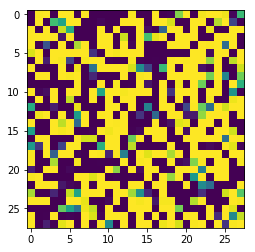

In [35]:
mlp.predict(test_images[i])
images = mlp.hidden_layers[0].a
plt.imshow(images.reshape(28,28))

7


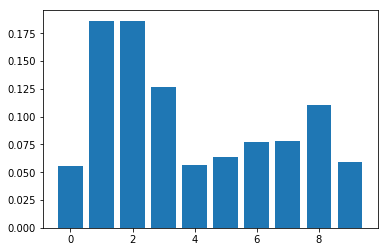

In [13]:
i = np.random.randint(10000)
print(test_labels[i])
plt.bar(range(10), mlp.predict(test_images[i]))
plt.show()

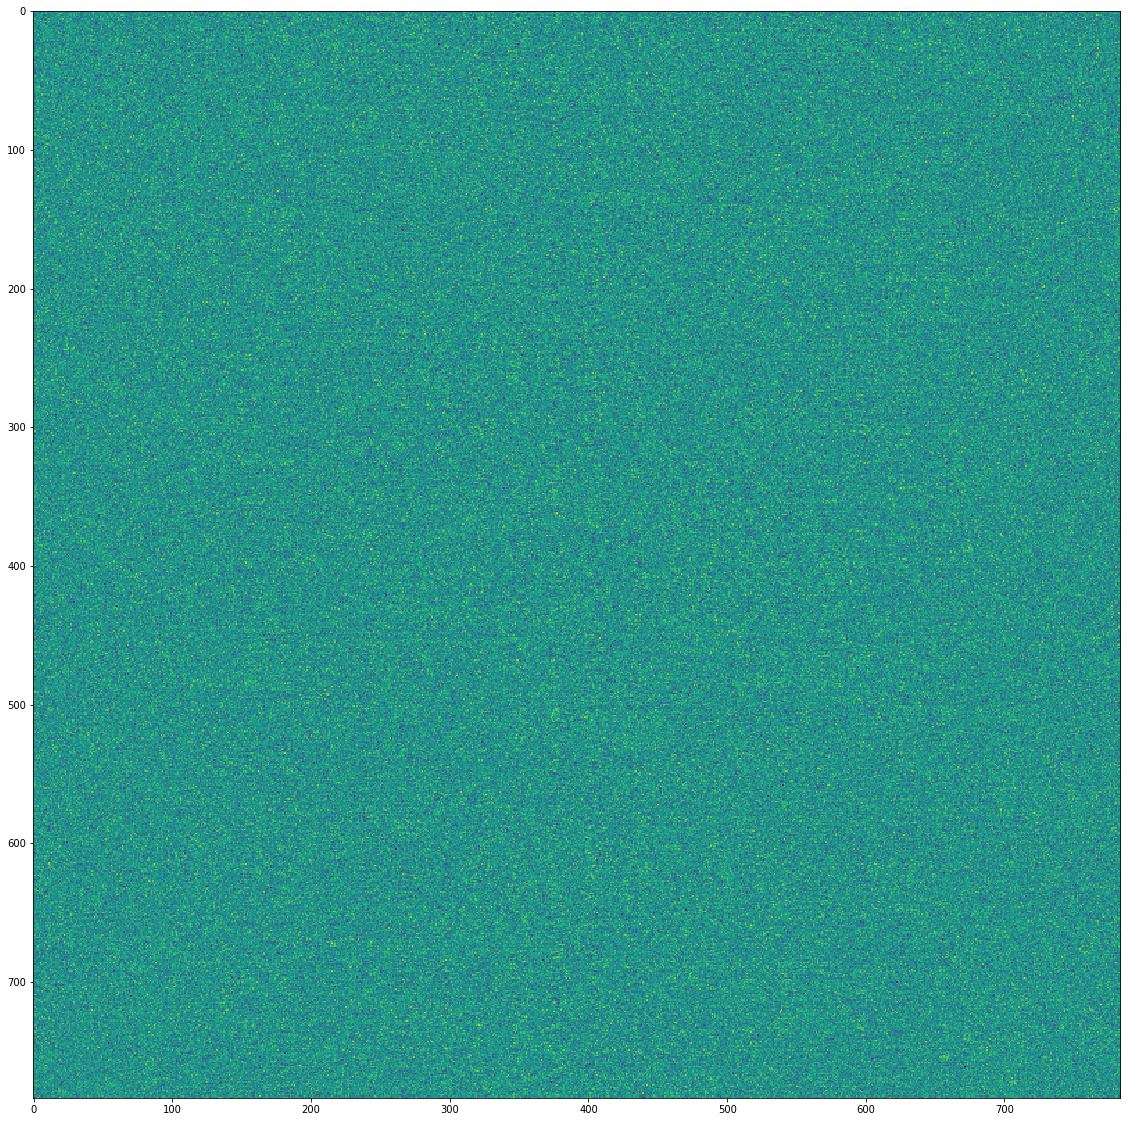

In [14]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(mlp.hidden_layers[0].W)
plt.show()

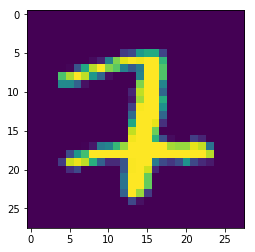

In [15]:
plt.imshow(test_images[i].reshape((28,28)))
plt.show()

In [16]:
np.random.seed(0)
hla = Layer(28*28, 28, np.tanh, lambda x:1-np.tanh(x)**2)
hlb = Layer(28, 10, np.tanh, lambda x:1-np.tanh(x)**2)
#hlc = Layer(28*10, 28, np.tanh, lambda x:1-np.tanh(x)**2)
#hld = Layer(28, 28, np.tanh, lambda x:1-np.tanh(x)**2)
mlp3 = MLP(28*28, 10, hla, hlb)

In [17]:
mlp3.train(train_images, train_labels, learning_rate = 0.0001, num=100000)
mlp3.test(test_images, test_labels)

0.7895

4


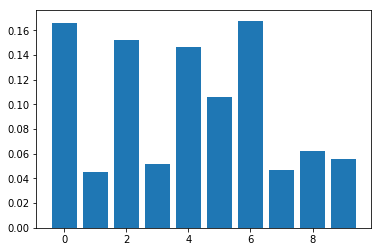

In [18]:
i = np.random.randint(test_labels.shape[0])
print(test_labels[i])
plt.bar(range(10), mlp3.predict(test_images[i]))
plt.show()

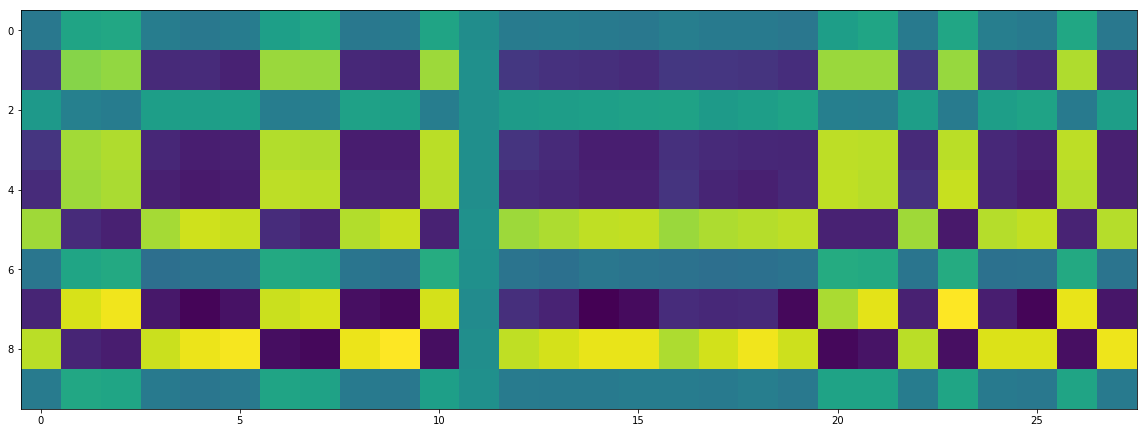

In [19]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(mlp3.hidden_layers[1].W)
plt.show()